In [1]:
import ase.io
import numpy as np
import copy
import matplotlib.pyplot as plt
import functools 

In [2]:
frames = ase.io.read('./gp_iter6_sparse9k.xml.xyz', ':')

In [3]:
print(len(frames))

2475


In [4]:
frames = [frame for frame in frames if ('dft_energy' in frame.info.keys()) or ('DFT_energy' in frame.info.keys())]
print(len(frames))

2475


In [5]:
dressed_energies_per_atom = []
# energy of one isolated Si atom
baseline_energy = frames[0].info['dft_energy'] 
for frame in frames:
    energy = frame.info['dft_energy'] if ('dft_energy' in frame.info.keys()) else frame.info['DFT_energy']
    frame.info['energy'] = energy
    energy -= baseline_energy*len(frame)
    frame.info['dressed_energy'] = energy
    energy /= len(frame)
    frame.info['dressed_energy_per_atom'] = energy
    dressed_energies_per_atom.append( energy )
len(frames)

2475

In [6]:
dressed_energies_per_atom = np.array(dressed_energies_per_atom)

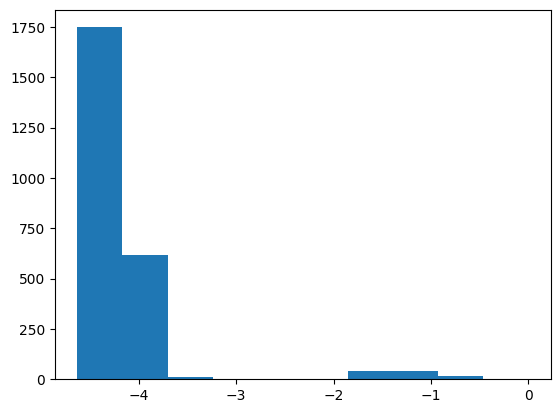

In [7]:
plt.hist(dressed_energies_per_atom)
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std=False).fit(dressed_energies_per_atom.reshape(-1,1))
scaled_dressed_energies_per_atom = scaler.transform(dressed_energies_per_atom.reshape(-1,1)).reshape(-1)
for i, frame in enumerate(frames):
    frame.info['scaled_dressed_energies_per_atom'] = scaled_dressed_energies_per_atom[i]


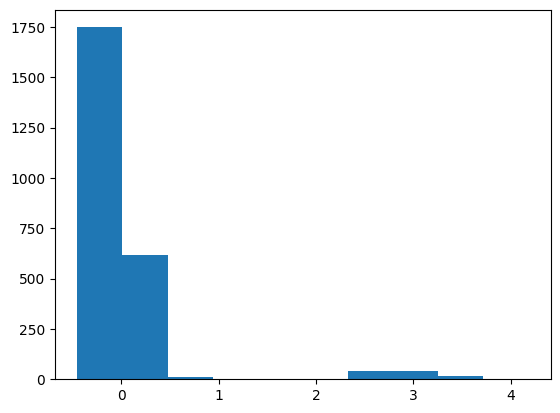

In [9]:
plt.hist(scaled_dressed_energies_per_atom)
plt.show()

# utils

In [10]:
from collections import defaultdict

import numpy as np
import torch
from typing import Dict, List, Tuple, TypeVar, Callable, Optional
import ase

import abc
AtomicStructure = TypeVar('AtomicStructure')

def structure_to_torch(structure : AtomicStructure,
        device : Optional[torch.device] = None,
        dtype: Optional[torch.dtype] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    :returns:
        Tuple of posititions, species, cell and periodic boundary conditions
    """
    if isinstance(structure, ase.Atoms):
        # dtype is automatically referred from the type in the structure object if None
        positions = torch.tensor(structure.positions, device=device, dtype=dtype)
        species = torch.tensor(structure.numbers, device=device)
        cell = torch.tensor(structure.cell.array, device=device, dtype=dtype)
        pbc = torch.tensor(structure.pbc, device=device)
        return positions, species, cell, pbc
    else:
        raise ValueError("Unknown atom type. We only support ase.Atoms at the moment.")

def build_neighborlist(positions: torch.Tensor, cell: torch.Tensor, pbc: torch.Tensor, cutoff : float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    assert positions.device == cell.device
    assert positions.device == pbc.device
    device = positions.device

    # will be replaced with something with GPU support
    pairs_i, pairs_j, cell_shifts = ase.neighborlist.primitive_neighbor_list(
        quantities="ijS",
        positions=positions.detach().cpu().numpy(),
        cell=cell.detach().cpu().numpy(),
        pbc=pbc.detach().cpu().numpy(),
        cutoff=cutoff,
        self_interaction=False,
        use_scaled_positions=False,
    )
    pairs_i = torch.tensor(pairs_i, device=device)
    pairs_j = torch.tensor(pairs_j, device=device)
    cell_shifts = torch.tensor(cell_shifts, device=device)

    pairs = torch.vstack([pairs_i, pairs_j]).T
    centers = torch.arange(len(positions), device=device)
    return centers, pairs, cell_shifts


class TransformerBase(metaclass=abc.ABCMeta):
    """
    Abstract class for extracting information of an AtomicStructure objects and processing it
    """
    @abc.abstractmethod
    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        pass

class TransformerProperty(TransformerBase):
    """
    Extracts property information out of an AtomicStructure using a function given as input
    """
    def __init__(self, property_name: List[str], get_property: List[Callable[[AtomicStructure], torch.Tensor]],
            device=None, dtype=None):
        if not(isinstance(get_property, list)):
            property_name = [property_name]
        if not(isinstance (get_property, list)):
            get_property = [get_property]
        self._get_property = get_property
        self._property_name = property_name
        self._device = device
        self._dtype = dtype


    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        return {self._property_name[i]: self._get_property[i](structure).to(device=self._device, dtype=self._dtype)
                for i in range(len(self._property_name))}

class TransformerNeighborList(TransformerBase):
    """
    Produces a neighbour list and with direction vectors from an AtomicStructure
    """
    def __init__(self, cutoff: float, device=None, dtype=None):
        self._cutoff = cutoff
        self._device = device
        self._dtype = dtype

    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        positions_i, species_i, cell_i, pbc_i = structure_to_torch(structure,
                dtype=self._dtype, device=self._device)
        centers_i, pairs_ij, cell_shifts_ij = build_neighborlist(positions_i, cell_i,
                pbc_i, self._cutoff)

        return {
            'positions': positions_i,
            'species': species_i,
            'cell': cell_i,
            'centers': centers_i,
            'pairs': pairs_ij,
            'cell_shifts': cell_shifts_ij
        }

# Temporary Dataset until we have an metatensor Dataset
class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self,
                 structures : List[AtomicStructure],
                 transformers : List[TransformerBase]):
        super().__init__()
        self.n_structures = len(structures)
        self._data = defaultdict(list)
        for structure in structures:
            for transformer in transformers:
                data_i = transformer(structure)
                for key in data_i.keys():
                    self._data[key].append(data_i[key])

    def __getitem__(self, idx):
        return {key: self._data[key][idx] for key in self._data.keys()}

    def __len__(self):
        return self.n_structures

def collate_nl(data_list, device=None, dtype=None):

    collated = {key: torch.concatenate([data[key].to(device=device) for data in data_list], dim=0)
                for key in filter(lambda x : x not in ["positions", "cell"], data_list[0].keys())}
    collated['positions'] = torch.concatenate([data["positions"] for data in data_list]).to(dtype=dtype, device=device)
    collated['cells'] = torch.stack([data["cell"] for data in data_list]).to(dtype=dtype, device=device)
    collated['structure_centers'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["centers"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_pairs'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["pairs"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_offsets'] = torch.tensor(
        np.cumsum([0] + [structure_data["positions"].shape[0] for structure_data in data_list[:-1]]),
        device=collated["positions"][0].device,
        dtype=torch.long
    ).to(device=device)
    return collated

In [11]:
CUTOFF = 6.

In [12]:
def get_dressed_energy_per_atom(frame) -> torch.Tensor:
    return torch.tensor([frame.info['scaled_dressed_energies_per_atom']])
    
dataset = InMemoryDataset(frames[:200],
                          [TransformerNeighborList(cutoff=CUTOFF),
                           TransformerProperty("scaled_dressed_energies_per_atom", get_dressed_energy_per_atom)])

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_nl, shuffle=False)

In [14]:
next(iter(dataloader))

{'species': tensor([14, 14]),
 'centers': tensor([0, 0]),
 'pairs': tensor([[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]

In [15]:
from torch import nn
import math

class CosineCutoff(nn.Module):
    r""" Behler-style cosine cutoff module.

    .. math::
       f(r) = \begin{cases}
        0.5 \times \left[1 + \cos\left(\frac{\pi r}{r_\text{cutoff}}\right)\right]
          & r < r_\text{cutoff} \\
        0 & r \geqslant r_\text{cutoff} \\
        \end{cases}

    """

    def __init__(self, cutoff: float):
        """
        Args:
            cutoff (float, optional): cutoff radius.
        """
        super(CosineCutoff, self).__init__()
        self.register_buffer("cutoff", torch.FloatTensor([cutoff]))

    def forward(self, input: torch.Tensor):
        return cosine_cutoff(input, self.cutoff)

def cosine_cutoff(input: torch.Tensor, cutoff: torch.Tensor):
    """ Behler-style cosine cutoff.

        .. math::
           f(r) = \begin{cases}
            0.5 \times \left[1 + \cos\left(\frac{\pi r}{r_\text{cutoff}}\right)\right]
              & r < r_\text{cutoff} \\
            0 & r \geqslant r_\text{cutoff} \\
            \end{cases}

        Args:
            cutoff (float, optional): cutoff radius.

        """

    # Compute values of cutoff function
    input_cut = 0.5 * (torch.cos(input * math.pi / cutoff) + 1.0)
    # Remove contributions beyond the cutoff radius
    input_cut *= (input < cutoff).float()
    return input_cut


class GaussianRBF(nn.Module):
    r"""Gaussian radial basis functions."""

    def __init__(
        self, n_rbf: int, cutoff: float, start: float = 0.0, trainable: bool = False
    ):
        """
        Args:
            n_rbf: total number of Gaussian functions, :math:`N_g`.
            cutoff: center of last Gaussian function, :math:`\mu_{N_g}`
            start: center of first Gaussian function, :math:`\mu_0`.
            trainable: If True, widths and offset of Gaussian functions
                are adjusted during training process.
        """
        super(GaussianRBF, self).__init__()
        self.n_rbf = n_rbf

        # compute offset and width of Gaussian functions
        offset = torch.linspace(start, cutoff, n_rbf)
        widths = torch.FloatTensor(
            torch.abs(offset[1] - offset[0]) * torch.ones_like(offset)
        )
        if trainable:
            self.widths = nn.Parameter(widths)
            self.offsets = nn.Parameter(offset)
        else:
            self.register_buffer("widths", widths)
            self.register_buffer("offsets", offset)

    def forward(self, inputs: torch.Tensor):
        return gaussian_rbf(inputs, self.offsets, self.widths)

def gaussian_rbf(inputs: torch.Tensor, offsets: torch.Tensor, widths: torch.Tensor):
    coeff = -0.5 / torch.pow(widths, 2)
    diff = inputs[..., None] - offsets
    y = torch.exp(coeff * torch.pow(diff, 2))
    return y


In [16]:

def get_cartesian_vectors(positions,
                          cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets):
    """
    Wraps direction vectors into TensorBlock object with metadata information
    """

    # calculate interatomic vectors
    pairs_offsets = structure_offsets[structure_pairs]
    shifted_pairs = pairs_offsets[:, None] + pairs
    shifted_pairs_i = shifted_pairs[:, 0]
    shifted_pairs_j = shifted_pairs[:, 1]
    direction_vectors = positions[shifted_pairs_j] - positions[shifted_pairs_i] + torch.einsum("ab, abc -> ac", cell_shifts.to(cells.dtype), cells[structure_pairs])

    # find associated metadata
    #pairs_i = pairs[:, 0]
    #pairs_j = pairs[:, 1]
    #labels = torch.stack([
    #    structure_pairs,
    #    pairs_i,
    #    pairs_j,
    #    species[shifted_pairs_i],
    #    species[shifted_pairs_j],
    #    cell_shifts[:, 0],
    #    cell_shifts[:, 1],
    #    cell_shifts[:, 2]
    #], dim=-1)
    return direction_vectors

# Spliney

In [17]:
from copy import deepcopy

class Spliney(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                self_interaction: int = 5,
                neighbor_interaction: int = 0,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._self_interaction = self_interaction
        self._neighbor_interaction = neighbor_interaction

        self._embedding = torch.nn.Sequential(
                            GaussianRBF(n_rbf=feature_size, cutoff=cutoff),
                            CosineCutoff(cutoff)
        )
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        # TODO rename to input_layers
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._self_interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._neighbor_interaction)])
        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._self_interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._neighbor_interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add offset to pair_i to make center index unique
        #pair_i = labels[:, 1]
        #structure_each_center = torch.cat([torch.tensor(sum(pair_i == i)*[i], dtype=torch.int64) 
        #                                                 for i in range(len(structure_offsets))])
        #pair_i = torch.cat([pair_i[pair_i == i] + structure_offsets[i] for i in range(len(structure_offsets))])
        #pair_i = structure_pairs
        #unique_centers = torch.tensor([structure_centers[i] + structure_offsets[i] for i in range(len(structure_offsets))])

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)

        pair_x = self._layers(embedding)
        # this pair_E_x is splined
        pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)

        for i in range(len(self._self_interaction_layers)):
            # central representation becomes weight
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            # new representation is computed
            pair_x = self._self_interaction_layers[i](embedding)
            pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) # double check cat, might be stack
            #  pair_E = pair_E * center_w[pairs_i] ? can replace above?

            #weights_center.index_add_(0, pair_x, weights_pair)
            #weights_center = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
            #weights_center.index_add_(0, structure_pairs, weights_pair)
            #
            #pair_x = self._self_interaction_layers[i](embedding)
            ## weights are computed from previous by suming center representation
            #weights_pair = self._self_interaction_liner_layers[i](pair_x)
            #pair_x *= weights_center
            #weights_center = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
            #weights_center.index_add_(0, structure_pairs, weights_pair)
            #
            ##pair_x = self._self_interaction_liner_layers[i](pair_x)
            ##center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
            ##center_x.index_add_(0, structure_pairs, pair_x)
            #
            ##pair_x = torch.tensor([embedding[structure_pairs[structure_pairs==i]] * center_x[i] for i in range(len(center_x))])
            #pair_x = self._self_interaction_layers[i](embedding)
            #pair_x *= weights_center
            ##center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
            ##center_x.index_add_(0, structure_pairs, pair_x)
            ##center_x = center_x
        
        for i in range(len(self._neighbor_interaction_layers)):
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            
            # new representation is computed
            pair_x = self._neighbor_interaction_layers[i](embedding)
            pair_E = self._neighbor_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = pair_E * center_w[pair_j]
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[pair_j] for j in range(len(pairs_j))])
            
        
        center_E = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
        center_E.index_add_(0, pairs_i, pair_E)
        #center_E.index_reduce_(0, pairs_i, pair_E, "mean")

        # this index_add_ is reproduced in the MD code
        #center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
        #center_x.index_add_(0, structure_pairs, pair_x)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        #y = self._output_layer(structure_x)
        #y = torch.sum(y, dim=-1)
        return y

In [18]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)
batch = next(iter(dataloader))
y = batch.pop('scaled_dressed_energies_per_atom')

model = Spliney(cutoff=CUTOFF, layers_per_interaction=5, self_interaction=0, dtype=torch.float64)
model.forward(**batch)

/tmp/ipykernel_275690/3148346043.py:114: UserWarning: index_reduce() is in beta and the API may change at any time. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1138.)
  y.index_reduce_(0, structure_centers, center_E, reduce="mean")


tensor([0.0000, 0.2920, 0.2637, 0.2637, 0.2731, 0.2919, 0.2826, 0.3013, 0.3014,
        0.3201, 0.3107, 0.2919, 0.2638, 0.2920, 0.3296, 0.3108, 0.3014, 0.3108,
        0.3014, 0.2825, 0.3013, 0.3202, 0.3296, 0.3296, 0.3108, 0.3202, 0.2824,
        0.2825, 0.3107, 0.3295, 0.3297, 0.3108, 0.3107, 0.3108, 0.3108, 0.3203,
        0.3202, 0.3108, 0.3109, 0.3202, 0.3296, 0.3295, 0.3295, 0.3201, 0.3390,
        0.3109, 0.2825, 0.3107, 0.3296, 0.3296, 0.3013, 0.3295, 0.3294, 0.3296,
        0.3295, 0.3108, 0.3107, 0.3201, 0.3014, 0.3013, 0.3201, 0.3201, 0.3202,
        0.3296, 0.3202, 0.3295, 0.3296, 0.3202, 0.3108, 0.3296, 0.3107, 0.3295,
        0.3295, 0.3295, 0.3201, 0.3296, 0.3295, 0.3296, 0.3202, 0.3483, 0.3108,
        0.3389, 0.3295, 0.3013, 0.3390, 0.3108, 0.3202, 0.3296, 0.3296, 0.3295,
        0.3390, 0.3295, 0.3296, 0.3295, 0.3296, 0.3201, 0.3578, 0.3390, 0.3295,
        0.3295], dtype=torch.float64, grad_fn=<SqueezeBackward0>)

In [19]:
y

tensor([ 4.1805e+00, -5.6445e-02,  5.9010e-02, -2.2576e-02,  2.6108e-02,
         2.1216e-02, -2.0571e-02, -3.9807e-02, -3.3502e-02,  4.1274e-02,
        -1.2426e-02, -7.1245e-02,  2.0948e-02, -2.8432e-02, -8.6263e-02,
        -4.4372e-02, -8.5924e-02, -5.0947e-02, -7.0792e-03,  5.8478e-02,
         2.7536e-02, -4.0116e-04, -8.2182e-03, -1.9296e-02, -7.8347e-02,
        -4.3808e-02,  6.3198e-03,  1.3588e-02,  1.3791e-02, -1.7708e-02,
        -7.5597e-02,  5.3542e-02,  4.8868e-02,  7.0688e-03, -5.2292e-03,
        -8.1301e-02, -4.6776e-02, -5.0999e-02, -5.3947e-02, -7.1742e-03,
        -7.2100e-02, -5.6128e-02, -6.1315e-02, -2.1426e-02,  1.4245e-01,
         5.8756e-02,  3.0088e-02, -4.4821e-02, -1.5990e-02,  3.9696e-02,
         3.3556e-02,  3.8578e-03, -3.6109e-02,  2.8281e-02,  1.0813e-02,
         1.6176e-02, -1.0802e-03,  2.2467e-02,  6.0416e-02, -1.6645e-02,
         2.7354e-02,  8.8307e-02,  5.0115e-02, -1.3700e-02, -3.3192e-03,
         1.4779e-02, -1.7340e-02, -1.1700e-02, -5.0

In [20]:
dataset[0].keys()

dict_keys(['positions', 'species', 'cell', 'centers', 'pairs', 'cell_shifts', 'scaled_dressed_energies_per_atom'])

# Training

In [ ]:
#torch.set_default_device("cuda:0")
DTYPE = torch.float32
DEVICE = "cpu"
collate_nl_and_move = functools.partial(collate_nl, dtype=DTYPE, device=DEVICE)

In [ ]:
big_dataset = InMemoryDataset(frames,
                          [TransformerNeighborList(cutoff=CUTOFF, dtype=DTYPE),
                           TransformerProperty("scaled_dressed_energies_per_atom",
                                               get_dressed_energy_per_atom, dtype=DTYPE)])

In [50]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [3/6, 1/6, 2/6], generator=generator)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, collate_fn=collate_nl_and_move, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, collate_fn=collate_nl_and_move, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, collate_fn=collate_nl_and_move, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
def loss_fn(pred, true):
    return torch.mean((pred - true)**2)



In [51]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=5, self_interaction=1, dtype=DTYPE, device=DEVICE)

In [ ]:
n_epoch = 50
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y)
        loss.backward()
        train_loss += loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()        
    test_loss = np.sqrt(test_loss / len(test_dataloader)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.71283 0.56078
0.70002 0.58091
0.69301 0.65164
0.69601 0.55963
0.72074 0.60807
0.69494 0.55901
0.72730 0.59368
0.68662 0.59040
0.70815 0.56039
0.70836 0.58649
0.70685 0.58131
0.70205 0.59194
0.69366 0.58277
0.69269 0.61650
0.69985 0.56070
0.69376 0.56015
0.70728 0.56012
0.70299 0.55954
0.69473 0.56019
0.68608 0.56025
0.70707 0.59317
0.69331 0.55985


In [ ]:
plt.loglog(train_loss)
plt.loglog(test_loss)
plt.savefig("training_results.png")
plt.show()
plt.close()

### RadialSpectrum

In [33]:
class RadialSpectrum(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                self_interaction: int = 5,
                neighbor_interaction: int = 2,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._self_interaction = self_interaction
        self._neighbor_interaction = neighbor_interaction

        self._embedding = torch.nn.Sequential(
                            GaussianRBF(n_rbf=feature_size, cutoff=cutoff),
                            CosineCutoff(cutoff) # maybe its this guy!
        )
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._self_interaction)])
        #self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._neighbor_interaction)])
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._self_interaction)])

    def forward_dist(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        return r
    
    def forward_embedding(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        return self._embedding(r)


    def forward_repr(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        embedding = self._embedding(r)
        center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype, device=embedding.device)
        center_x.index_add_(0, pairs_i, embedding)

        structure_x = torch.zeros(len(structure_offsets), center_x.shape[-1], dtype=center_x.dtype, device=center_x.device)
        structure_x.index_reduce_(0, structure_centers, center_x, reduce="mean")

        return structure_x
        
    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)
        center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype, device=embedding.device)
        center_x.index_add_(0, pairs_i, embedding)
        center_x = self._layers(center_x)
        center_E = self._output_layer(center_x)
        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

In [34]:
model_rs = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=5, self_interaction=0, neighbor_interaction=0, dtype=DTYPE, device=DEVICE)

In [35]:
n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model_rs.forward(**batch)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y)
        loss.backward()
        train_loss += loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model_rs.forward(**batch)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()        
    test_loss = np.sqrt(test_loss / len(test_dataloader)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.22509 0.24378
0.21789 0.25481
0.22126 0.25055
0.22873 0.24548
0.24349 0.24756
0.23188 0.24447
0.21771 0.24884
0.24542 0.24793
0.22396 0.25164
0.23339 0.25480


KeyboardInterrupt: 

In [ ]:
model_rs = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=0)

In [ ]:
big_dataloader = torch.utils.data.DataLoader(big_dataset, batch_size=100, collate_fn=collate_nl, shuffle=True)

In [ ]:
rs_repr = []
ys = []
for batch in big_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_repr(**batch)
    rs_repr.append(x)
    

In [ ]:
X = torch.cat(rs_repr)

In [ ]:
y = torch.cat(ys)

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
w = torch.linalg.lstsq(X, y).solution

In [ ]:
loss_fn(X@w, y)

In [ ]:
for i in torch.randint(len(X), size=(10,)):
    plt.plot(X[i].detach().numpy())
plt.show()
plt.close()

In [ ]:
rs_embedding = []
ys = []
for batch in whole_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_embedding(**batch)
    rs_embedding.append(x)
X = torch.cat(rs_embedding)

In [ ]:
for i in torch.randint(len(X), size=(10,)):
    plt.plot(X[i].detach().numpy())
plt.show()
plt.close()

In [ ]:
linear_embedding = torch.nn.Sequential(
                    GaussianRBF(n_rbf=128, cutoff=CUTOFF),
                    #CosineCutoff(CUTOFF)
)

In [ ]:
plt.plot(linear_embedding(torch.linspace(0,5,10)).detach().numpy().T) 
plt.show()
plt.close()

In [ ]:
plt.plot(linear_embedding(torch.linspace(0,5,10)).detach().numpy().sum(0)) 
plt.show()
plt.close()

In [ ]:
linear_embedding(torch.linspace(0,5,100)).shape